## Directly Shared Domains

**Purpose**: identify which media outlets resonate directly with congressional Republicans over the 2016-2020 period


In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from pprint import pprint
import datetime

%matplotlib inline
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format

In [2]:
# matplotlib is logged even though disable_existing_loggers=yes in logging_config.yaml
# https://stackoverflow.com/a/51529172/7016397
# workaround is to manually set the level before creating my logger
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from usrightmedia.shared.loggers import get_logger
LOGGER = get_logger(filename = '02-shared-domains', logger_type='main')

In [3]:
import urlexpander

In [5]:
from inca import Inca
myinca = Inca()

In [36]:
# for exporting df_urls
urls_dir = os.path.join("..", "..", "data", "03-analysis")
figs_dir = os.path.join("..", "..", "figures", "direct")

## 1.0 Merge the data

### 1.1 Check that each outlet's netloc values are included in `media_references.py`

In [7]:
outlet_doctypes = [
    "americanrenaissance",
    "breitbart",
    "dailycaller",
    "dailystormer",
    "foxnews",
    "gatewaypundit",
    "infowars",
    "newsmax",
    "oneamericanews",
    "rushlimbaugh",
    "seanhannity",
    "vdare",
    "washingtonexaminer",
]

In [8]:
def check_netlocs(outlet_doctypes):
    dfs = []
    for doctype in outlet_doctypes:
        doctype_urls = [doc["_source"]["resolved_url"] for doc in myinca.database.doctype_generator(doctype)]
        df = pd.DataFrame(doctype_urls).rename(columns={0:"resolved_url"})
        df["standardized_netloc"] = df["resolved_url"].map(lambda x: urlexpander.url_utils.standardize_url(x,
                                                                                                          remove_scheme=True,
                                                                                                          replace_netloc_with_domain=False,
                                                                                                          remove_path=True,
                                                                                                          remove_query=True,
                                                                                                          remove_fragment=True,
                                                                                                          to_lowercase=True))
        df["url_netloc"] = df["standardized_netloc"].str.replace('www.', '', regex=False) # align field format before merging outlet-level dataframe with doc-level dataframe
        df["doctype"] = doctype
        dfs.append(df)
    df_all_doctypes = pd.concat(dfs)
    return df_all_doctypes

In [9]:
df_doctype_urls = check_netlocs(outlet_doctypes)
df_doctype_urls.groupby(["doctype", "url_netloc"]).size()

100%|██████████| 71710/71710 [00:21<00:00, 3353.02it/s]


doctype              url_netloc                 
americanrenaissance                                     67
                     amren.com                        9771
breitbart                                              670
                     breitbart.com                  148526
                     breitbart.com:80                   44
                                                     ...  
washingtonexaminer   m.washingtonexaminer.com           25
                     m.washingtonexaminer.com:80         6
                     washingtonexaminer.com          58415
                     washingtonexaminer.com:80        4868
                     ww2.washingtonexaminer.com          1
Length: 77, dtype: int64

In [10]:
len(df_doctype_urls)

924027

### 1.2 Merge dataframes related to outlets' URL domain names and ideological category

In [11]:
from usrightmedia.shared.media_references import get_media_outlet_ideo, get_media_outlet_netloc

df_ideo = get_media_outlet_ideo()
df_netloc = get_media_outlet_netloc(include_national = True,
                                    include_regional = False,
                                    include_gop = False,
                                    include_government = False)

In [12]:
df_outlets = df_netloc.merge(right=df_ideo, how="left", on="outlet_std")
# keep outlets which are assigned an ideo category
df_outlets = df_outlets.loc[df_outlets["ideo_category"].notna()].reset_index(drop=True)
df_outlets = df_outlets[["outlet", "outlet_std", "url_netloc", "is_selected_outlet", "pew_libdem", "pew_consrep", "pew_libdem_consrep_diff", "ideo_category", "ideo_subcategory", "ideo_left2right"]]
df_outlets

,outlet,outlet_std,url_netloc,is_selected_outlet,pew_libdem,pew_consrep,pew_libdem_consrep_diff,ideo_category,ideo_subcategory,ideo_left2right
0,ABC News,abcnews,abcnews.go.com,False,22.0,21.0,1.0,mixed,mixed,21.0
1,ABC News,abcnews,abcn.ws,False,22.0,21.0,1.0,mixed,mixed,21.0
2,American Renaissance,americanrenaissance,amren.com,True,NaN,NaN,-999.0,right,alternative right,34.0
3,BBC,bbc,bbc.com,False,42.0,14.0,28.0,left,left,8.0
4,Business Insider,businessinsider,businessinsider.com,False,40.0,20.0,20.0,left,left,16.0
...,...,...,...,...,...,...,...,...,...,...
71,Washington Examiner,washingtonexaminer,washingtonexaminer.com,True,14.0,44.0,-29.0,right,established right,24.0
72,Washington Examiner,washingtonexaminer,m.washingtonexaminer.com,True,14.0,44.0,-29.0,right,established right,24.0
73,Washington Examiner,washingtonexaminer,washex.am,True,14.0,44.0,-29.0,right,established right,24.0
74,Washington Post,washingtonpost,washingtonpost.com,False,45.0,12.0,33.0,left,left,7.0


### 1.3 Make dataframe of URLs which were (re-)tweeted by congressional Republicans

In [13]:
docs = [doc for doc in myinca.database.doctype_generator("tweets2_url")]
docs = [{key: doc["_source"][key] for key in ["url_id", "created_at", "username", "standardized_url", "standardized_netloc", "standardized_domain", "standardized_url_is_generic", "urlexpander_error"]} for doc in docs]
df_docs = pd.DataFrame(docs)
df_docs["created_at"] = pd.to_datetime(df_docs["created_at"], unit="ms")
df_docs["created_at_year"] = df_docs["created_at"].map(lambda d: datetime.datetime(year=d.year, month=1, day=1))
df_docs

100%|██████████| 285447/285447 [00:42<00:00, 6686.95it/s] 


,url_id,created_at,username,standardized_url,standardized_netloc,standardized_domain,standardized_url_is_generic,urlexpander_error,created_at_year
0,1016809976789159937_0,2018-07-10 22:22:44,KenCalvert,www.washingtonexaminer.com/policy/economy/hire...,www.washingtonexaminer.com,washingtonexaminer.com,False,no error,2018-01-01
1,684150993408376832_0,2016-01-04 23:14:42,RoyBlunt,usa.gov/__client_error__,1.usa.gov,usa.gov,False,CLIENT_ERROR,2016-01-01
2,942778990250602496_0,2017-12-18 15:30:01,RepStefanik,majorityleader.gov/__client_error__,www.majorityleader.gov,majorityleader.gov,False,CLIENT_ERROR,2017-01-01
3,1012370070755053568_0,2018-06-28 16:20:08,KenCalvert,calvert.house.gov/media/press-releases/rep-cal...,calvert.house.gov,house.gov,False,no error,2018-01-01
4,940290485930856448_0,2017-12-11 18:41:36,RepStefanik,majorityleader.gov/__client_error__,www.majorityleader.gov,majorityleader.gov,False,CLIENT_ERROR,2017-01-01
...,...,...,...,...,...,...,...,...,...
285442,905880145650745344_0,2017-09-07 19:47:11,RepJasonSmith,www.facebook.com/login/?next=https%3a%2f%2fwww...,www.facebook.com,facebook.com,False,no error,2017-01-01
285443,728604925274501121_0,2016-05-06 15:18:45,RepGarrett,usa.gov/__client_error__,1.usa.gov,usa.gov,False,CLIENT_ERROR,2016-01-01
285444,715915945286451201_0,2016-04-01 14:57:17,RepGarrett,spkrryan.us/__client_error__,spkrryan.us,spkrryan.us,False,CLIENT_ERROR,2016-01-01
285445,703256429155770370_0,2016-02-26 16:32:53,RepGarrett,usa.gov/__client_error__,1.usa.gov,usa.gov,False,CLIENT_ERROR,2016-01-01


### 1.4 Merge the outlet-level dataframe and (re-)tweeted URL dataframe based on URL netloc
- each row is a URL along with its associated outlet's ideo info

In [14]:
df_docs = df_docs.loc[~df_docs["standardized_url_is_generic"]].reset_index(drop=False)

# this step is a filter for URLs from selected outlets (i.e., right-wing media outlets)
# trim away "www." and ":80" since those differences are irrelevant for merging
df_docs["url_netloc"] = df_docs["standardized_netloc"].str.replace('www.', '', regex=False).str.replace(':80', '', regex=False)
df_urls = df_docs.merge(right=df_outlets, how="inner", on="url_netloc")
df_urls=df_urls[["url_id", "created_at", "created_at_year", "username",
                 "standardized_url", "url_netloc", "urlexpander_error",
                 "outlet", "outlet_std", "is_selected_outlet",
                 "pew_libdem", "pew_consrep", "pew_libdem_consrep_diff",
                 "ideo_category", "ideo_subcategory", "ideo_left2right"]]
len(df_urls)

36019

In [15]:
df_urls.head()

,url_id,created_at,created_at_year,username,standardized_url,url_netloc,urlexpander_error,outlet,outlet_std,is_selected_outlet,pew_libdem,pew_consrep,pew_libdem_consrep_diff,ideo_category,ideo_subcategory,ideo_left2right
0,1016809976789159937_0,2018-07-10 22:22:44,2018-01-01,KenCalvert,www.washingtonexaminer.com/policy/economy/hire...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,14.0,44.0,-29.0,right,established right,24.0
1,706936239220330498_0,2016-03-07 20:15:08,2016-01-01,KenCalvert,www.washingtonexaminer.com/how-a-new-bill-to-f...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,14.0,44.0,-29.0,right,established right,24.0
2,735190770035138560_0,2016-05-24 19:28:33,2016-01-01,RepComstock,www.washingtonexaminer.com/lawmaker-let-privat...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,14.0,44.0,-29.0,right,established right,24.0
3,971799132707926016_0,2018-03-08 17:25:43,2018-01-01,RepByrne,www.washingtonexaminer.com/how-to-end-governme...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,14.0,44.0,-29.0,right,established right,24.0
4,1204042988285919233_0,2019-12-09 14:19:53,2019-01-01,RepChrisStewart,www.washingtonexaminer.com/opinion/utah-republ...,washingtonexaminer.com,no error,Washington Examiner,washingtonexaminer,True,14.0,44.0,-29.0,right,established right,24.0


- export directly shared domains

In [16]:
df_urls.to_pickle(os.path.join(urls_dir, "direct_shared_domains.pkl"))

- all URLs

In [17]:
# check merge; shows how many URLs are from recognized outlets (including non-right-wing media)
len(df_docs.loc[df_docs["url_netloc"].isin(df_outlets["url_netloc"])])

36019

In [18]:
# number of URLs which are selected right-wing media outlets
df_urls.groupby("is_selected_outlet").size()

is_selected_outlet
False    22058
True     13961
dtype: int64

- unique URLs

In [19]:
df_urls["standardized_url"].nunique()

24764

In [20]:
df_urls.drop_duplicates(subset=["standardized_url"], keep="first").groupby("is_selected_outlet").size()

is_selected_outlet
False    15355
True      9409
dtype: int64

- URL matching is based on the outlet-doctype's `standardized_url` and the `tweets2_url`'s `standardized_url` matching. Since `standardized_url` is based on post-scraping URLs, this value can be a generic URL (e.g., server did not return an error and re-directed to a generic landing page).
- We do not want to count these generic 'matches' as true matches, so the `check_url()` function also requires that the outlet's document has the `should_include` indicator equal to `True`.

In [21]:
def check_url(url_to_match):
    search_param = {
                    "_source": ["_id", "standardized_url"],
                    "size": 10000,
                    "query": {
                        "bool": {
                            "filter": [
                                {"terms": {
                                            "doctype": [
                                              "americanrenaissance",
                                              "breitbart",
                                              "dailycaller",
                                              "dailystormer",
                                              "foxnews",
                                              "gatewaypundit",
                                              "infowars",
                                              "newsmax",
                                              "oneamericanews",
                                              "rushlimbaugh",
                                              "seanhannity",
                                              "vdare",
                                              "washingtonexaminer"
                                            ]
                                          }},
                                {"term": {"standardized_url.keyword": url_to_match}},
                                {"term": {"should_include": True}},
                            ]
                        }
                    },
                }

    res = myinca.database._client.search(index=myinca.database._elastic_index, body=search_param)
    hits = res["hits"]["hits"]
    matched_ids = [d["_id"] for d in hits]
    
    
    return matched_ids

In [22]:
%%time
# check: percent of unique Media Cloud URLs from selected outlets which were (re-)tweeted by 1+ politician
tw_mc_match = {}
for n, url in enumerate(df_urls.loc[df_urls["is_selected_outlet"]]["standardized_url"]):
    checked = check_url(url)
    if len(checked) > 0:
        tw_mc_match[f"url_{n}"] = {"url": url,
                                    "doc_ids": checked}
        
num_matches = len(tw_mc_match.keys())
uniq_mc_urls = df_urls.loc[df_urls["is_selected_outlet"]]["standardized_url"].nunique()

print(f"{num_matches} (re-)tweeted URLs matched into Media Cloud URLs")
print(f"{uniq_mc_urls} unique Media Cloud URLs")

7059 (re-)tweeted URLs matched into Media Cloud URLs
9409 unique Media Cloud URLs
CPU times: user 17 s, sys: 1.76 s, total: 18.8 s
Wall time: 1min 10s


In [23]:
tw_mc_match["url_26"]

{'url': 'www.washingtonexaminer.com/ice-124-illegal-immigrants-released-from-jail-later-charged-in-138-murder-cases',
 'doc_ids': ['WashingtonExaminer_1036420208']}

## 2.0 Yearly counts

In [24]:
# dataframe which counts the number of (re-)tweeted URLs per outlet by year
df_counts = df_urls.groupby([lambda d: df_urls["created_at"][d].year, "outlet"],  dropna=False)\
                   .count()[["url_id"]]\
                   .reset_index()\
                   .rename(columns={"level_0":"year", "url_id":"count"})\
                   .merge(right=df_ideo, how="left", on="outlet")

with pd.option_context("display.max_rows", None):
    display(df_counts.head())

,year,outlet,count,outlet_std,pew_libdem,pew_consrep,pew_libdem_consrep_diff,ideo_category,ideo_subcategory,ideo_left2right
0,2016,ABC News,167,abcnews,22.0,21.0,1,mixed,mixed,21
1,2016,BBC,23,bbc,42.0,14.0,28,left,left,8
2,2016,Breitbart,136,breitbart,1.0,80.0,-79,right,alternative right,27
3,2016,Business Insider,22,businessinsider,40.0,20.0,20,left,left,16
4,2016,BuzzFeed,16,buzzfeed,40.0,17.0,23,left,left,11


## 3. Plots

In [25]:
%matplotlib inline

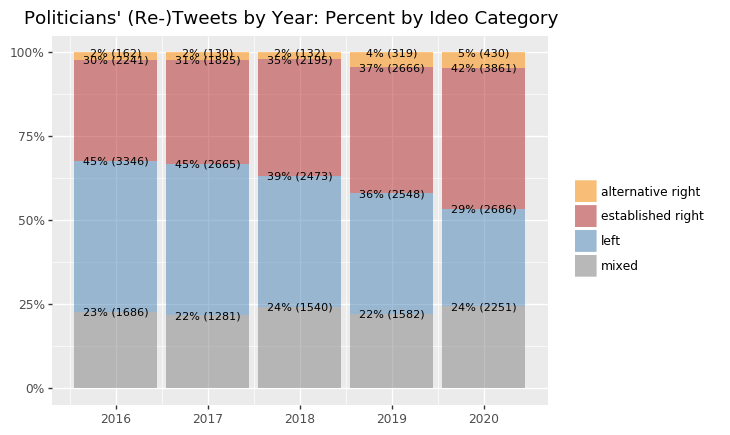

<ggplot: (8787138646956)>

In [157]:
def count2pct_subcat(counts):
    md_count = np.asarray(counts).reshape((4,5)) # multi-dim array with 4 rows (left/mixed/est-right/alt-right) and 5 columns (2016-2020)
    md_pct = md_count/md_count.sum(axis=0) # calculate percent of each cell by column
    sd_pct = md_pct.flatten() # plotnine requires a 1D array
    fmt = [f'{p*100:.0f}% ({counts[n]})' for n, p in enumerate(sd_pct)] # format the presentation of the 1D array
    return fmt

plt_ideo_subcat_pct = (p9.ggplot(df_urls,
                       p9.aes(x='created_at_year')) +
                         p9.geom_bar(p9.aes(fill='ideo_subcategory'), position='fill', alpha=0.5) +
                         p9.scale_fill_manual(values=['darkorange', 'firebrick', 'steelblue', 'grey']) +
                         p9.geom_text(p9.aes(label='stat(count2pct_subcat(count))',group='ideo_subcategory'),
                                   position='fill',
                                   stat='count',
                                   va='center',
                                   size=8) + 
                         p9.scale_y_continuous(labels=percent_format()) + 
                         p9.scale_x_datetime(labels=date_format("%Y")) +
                         p9.labs(title="Politicians' (Re-)Tweets by Year: Percent by Ideo Category",
                              fill='',
                              x='',
                              y=''))


display(plt_ideo_subcat_pct)

In [158]:
plt_ideo_subcat_pct.save(filename=os.path.join(figs_dir, "png", "ideo_groups_shared_by_year_direct.png"), height=5.5, width=5.5, units="in", dpi=600)

/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5.5 x 5.5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/direct/png/ideo_groups_shared_by_year_direct.png


In [168]:
# https://stackoverflow.com/a/37148895
pdata = pd.pivot_table(df_urls, index=['created_at_year', 'ideo_subcategory'],aggfunc='size')
pdata = pdata.to_frame().rename(columns={0:'Count'})
pdata['Percent'] = pdata.groupby(level=0).transform(lambda x: (x / x.sum())*100)
pdata['Label'] =  pdata.agg(lambda x: f"{round(x['Percent'], 1)}% \n ({int(x['Count'])})", axis=1)
pdata

Count    Percent            Label
created_at_year ideo_subcategory                                    
2016-01-01      alternative right    162   2.178884    2.2% \n (162)
                established right   2241  30.141224  30.1% \n (2241)
                left                3346  45.003362  45.0% \n (3346)
                mixed               1686  22.676530  22.7% \n (1686)
2017-01-01      alternative right    130   2.203016    2.2% \n (130)
                established right   1825  30.926962  30.9% \n (1825)
                left                2665  45.161837  45.2% \n (2665)
                mixed               1281  21.708185  21.7% \n (1281)
2018-01-01      alternative right    132   2.082019    2.1% \n (132)
                established right   2195  34.621451  34.6% \n (2195)
                left                2473  39.006309  39.0% \n (2473)
                mixed               1540  24.290221  24.3% \n (1540)
2019-01-01      alternative right    319   4.483486    4.5% \n (319)
                established right   2666  37.470134  37.5% \n (2666)
                left                2548  35.811665  35.8% \n (2548)
                mixed               1582  22.234715  22.2% \n (1582)
2020-01-01      alternative right    430   4.659731    4.7% \n (430)
                established right   3861  41.840052  41.8% \n (3861)
                left                2686  29.107065  29.1% \n (2686)
                mixed               2251  24.393151  24.4% \n (2251)

In [169]:
pdata[pdata.index.get_level_values('ideo_subcategory') == 'alternative right']['Percent']

created_at_year  ideo_subcategory 
2016-01-01       alternative right    2.178884
2017-01-01       alternative right    2.203016
2018-01-01       alternative right    2.082019
2019-01-01       alternative right    4.483486
2020-01-01       alternative right    4.659731
Name: Percent, dtype: float64

In [170]:
pdata[pdata.index.get_level_values('ideo_subcategory') == 'established right']['Percent']

created_at_year  ideo_subcategory 
2016-01-01       established right    30.141224
2017-01-01       established right    30.926962
2018-01-01       established right    34.621451
2019-01-01       established right    37.470134
2020-01-01       established right    41.840052
Name: Percent, dtype: float64

In [171]:
pdata[pdata.index.get_level_values('ideo_subcategory') == 'left']['Percent']

created_at_year  ideo_subcategory
2016-01-01       left                45.003362
2017-01-01       left                45.161837
2018-01-01       left                39.006309
2019-01-01       left                35.811665
2020-01-01       left                29.107065
Name: Percent, dtype: float64

In [172]:
pdata[pdata.index.get_level_values('ideo_subcategory') == 'mixed']['Percent']

created_at_year  ideo_subcategory
2016-01-01       mixed               22.676530
2017-01-01       mixed               21.708185
2018-01-01       mixed               24.290221
2019-01-01       mixed               22.234715
2020-01-01       mixed               24.393151
Name: Percent, dtype: float64

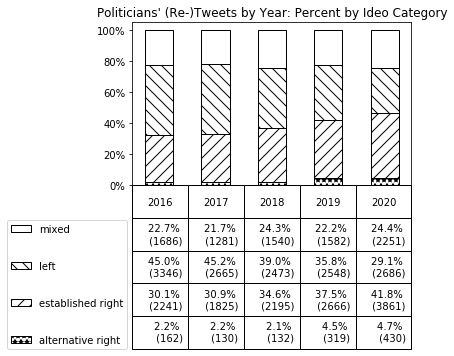

In [234]:
# chart code modified from https://matplotlib.org/3.5.0/gallery/misc/table_demo.html#sphx-glr-gallery-misc-table-demo-py
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
# https://stackoverflow.com/a/13652262
years = pdata.index.levels[0].year

# https://stackoverflow.com/a/39566040
plt.rc('axes', labelsize=10)


fig, ax = plt.subplots(figsize=(5,3))
# https://matplotlib.org/3.5.0/gallery/shapes_and_collections/hatch_style_reference.html
columns = years
rows = pdata.index.levels[1].values
patterns = ["**", "//", "\\\\", ""]
# https://stackoverflow.com/a/50414067
ideo_cats = ['alternative right', 'established right', 'left', 'mixed']
data = []
data_labels = []
for ideo_cat in ideo_cats:
    data.append(pdata[pdata.index.get_level_values('ideo_subcategory') == ideo_cat]['Percent'].values)
    data_labels.append(pdata[pdata.index.get_level_values('ideo_subcategory') == ideo_cat]['Label'].values)
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.5

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))
# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax.bar(index, data[row], bar_width, bottom=y_offset, hatch=patterns[row], label=ideo_cats[row], fill=False)
    y_offset = y_offset + data[row]
    cell_text.append([x for x in data_labels[row]])
# Reverse patterns and text labels to display the last value at the top.
patterns = patterns[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
tbl = ax.table(cellText=cell_text,
                      # rowLabels=rows[::-1],
                      colLabels=columns,
                      loc='bottom',
                      bbox=[0.0,-1,1,1])
    
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
ax.xaxis.set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title("Politicians' (Re-)Tweets by Year: Percent by Ideo Category")

# https://stackoverflow.com/a/43439132
# https://stackoverflow.com/a/52168981
# match legend order with stack order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=reversed(handles), labels=reversed(labels), bbox_to_anchor=(0.0,-1.18,0.0,1), labelspacing=2.7, fontsize=10)
fig.savefig(fname=os.path.join(figs_dir, "png", "ideo_groups_shared_by_year_direct_bw.png"), bbox_inches="tight")
plt.show()

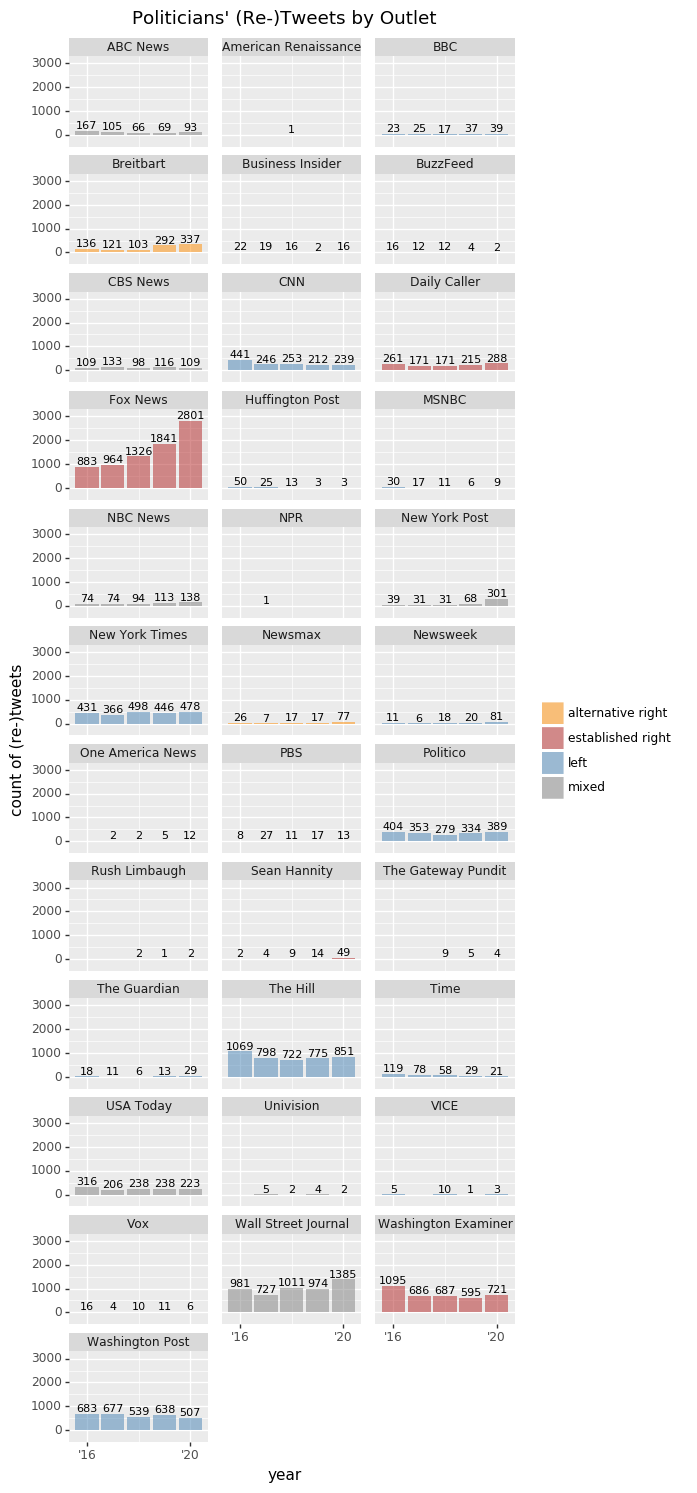

<ggplot: (8787139899417)>

In [46]:
plt_outlet = (p9.ggplot(data=df_urls,
                    mapping=p9.aes(x='created_at_year'))
                 + p9.geom_bar(p9.aes(fill='ideo_subcategory'), stat='count',
                            alpha = 0.5)
                 + p9.scale_fill_manual(values=['darkorange', 'firebrick', 'steelblue', 'grey'])
                 + p9.geom_text(
                     p9.aes(label=p9.after_stat('count')),
                     stat='count',
                     va='bottom',
                     size=8
                 )
                 + p9.scale_x_datetime(labels=date_format("'%y"), date_breaks='4 years')
                 + p9.scale_y_continuous(expand=(0,500)) # to prevent Fox label from getting cutoff
                 + p9.facet_wrap("outlet", labeller='label_value', ncol=3)
                 + p9.theme(figure_size=(5.75, 18),
                     subplots_adjust={'wspace': 0.10,
                                      'hspace': 0.30
                                     })
                 + p9.labs(title="Politicians' (Re-)Tweets by Outlet",
                        fill='',
                        x='year',
                        y='count of (re-)tweets')
                )

display(plt_outlet)

In [47]:
pd.DataFrame(df_urls.groupby(["ideo_subcategory","outlet"]).size().reset_index(drop=False)).rename(columns={0: "count"})

,ideo_subcategory,outlet,count
0,alternative right,American Renaissance,1
1,alternative right,Breitbart,989
2,alternative right,Newsmax,144
3,alternative right,One America News,21
4,alternative right,The Gateway Pundit,18
5,established right,Daily Caller,1106
6,established right,Fox News,7815
7,established right,Rush Limbaugh,5
8,established right,Sean Hannity,78
9,established right,Washington Examiner,3784


In [68]:
plt_outlet.save(filename=os.path.join(figs_dir, "png", "outlets_shared_by_year_direct.png"), height=5.75, width=18, units="in", dpi=600)

/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 18 x 5.75 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/direct/png/outlets_shared_by_year_direct.png


/home/jovyan/.local/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


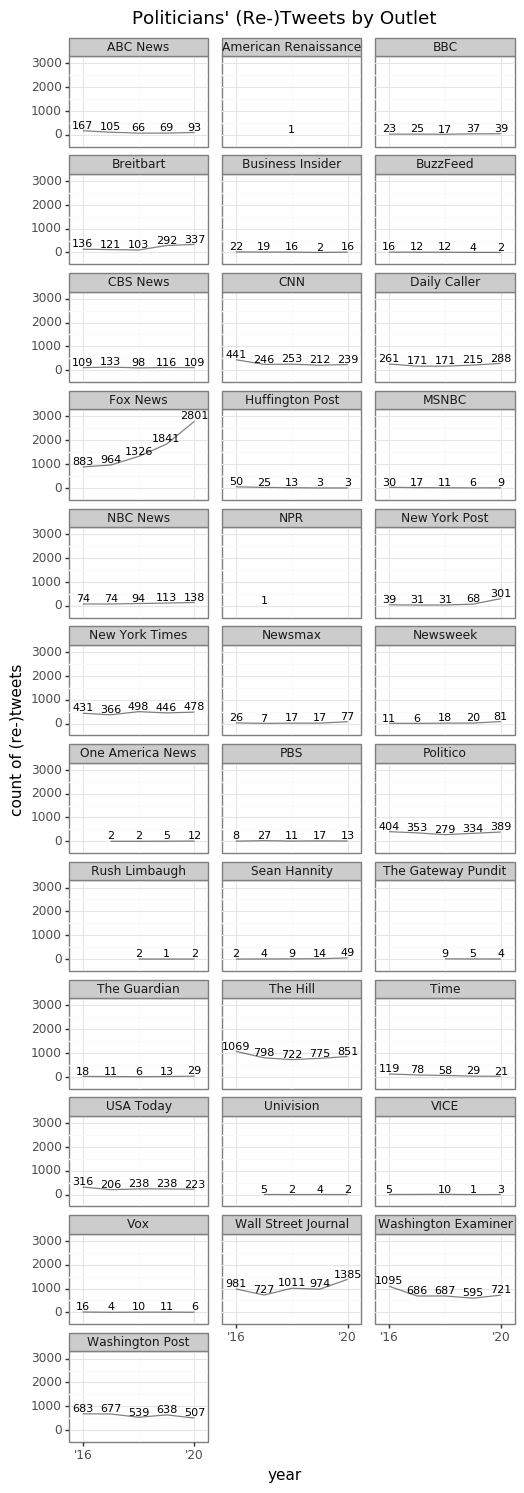

<ggplot: (8787138159454)>

In [243]:
plt_outlet_bw = (p9.ggplot(data=df_urls,
                    mapping=p9.aes(x='created_at_year'))
                 + p9.geom_line(color='black', stat='count', alpha = 0.5)
                 # + p9.scale_fill_manual(values=['black', 'darkgrey'])
                 + p9.geom_text(
                     p9.aes(label=p9.after_stat('count')),
                     stat='count',
                     va='bottom',
                     size=8
                 )
                 + p9.scale_x_datetime(labels=date_format("'%y"), date_breaks='4 years', expand=(0, 180, 0, 180))
                 + p9.scale_y_continuous(expand=(0,500)) # to prevent Fox label from getting cutoff
                 + p9.facet_wrap("outlet", labeller='label_value', ncol=3)
                 + p9.theme_bw()
                 + p9.theme(figure_size=(5.75, 18),
                     subplots_adjust={'wspace': 0.10,
                                      'hspace': 0.30
                                     })
                 + p9.labs(title="Politicians' (Re-)Tweets by Outlet",
                        fill='',
                        x='year',
                        y='count of (re-)tweets')
                )

display(plt_outlet_bw)

In [244]:
plt_outlet_bw.save(filename=os.path.join(figs_dir, "png", "outlets_shared_by_year_direct_bw.png"), height=18, width=5.75, units="in")

/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5.75 x 18 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/direct/png/outlets_shared_by_year_direct_bw.png
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


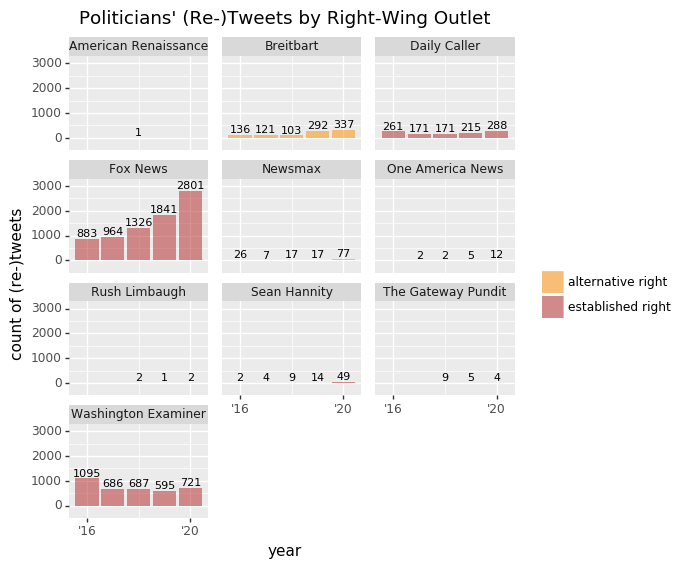

<ggplot: (8786867726574)>

In [79]:
plt_outlet_right = (p9.ggplot(
                    data=df_urls.loc[df_urls["ideo_category"]=="right"], 
                    mapping=p9.aes(x='created_at_year'))
                 + p9.geom_bar(p9.aes(fill='ideo_subcategory'), stat='count', alpha = 0.5)
                 + p9.scale_fill_manual(values=['darkorange', 'firebrick'])
                 + p9.geom_text(
                     p9.aes(label=p9.after_stat('count')),
                     stat='count',
                     va='bottom',
                     size=8
                 )
                 + p9.scale_y_continuous(expand=(0,500)) # to prevent Fox label from getting cutoff
                 + p9.scale_x_datetime(labels=date_format("'%y"), date_breaks='4 years')
                 + p9.facet_wrap('outlet', labeller='label_value', ncol=3)
                 + p9.theme(figure_size=(5.75, 6.0),
                         subplots_adjust={'wspace': 0.10,
                                          'hspace': 0.30
                                         }
                        )
                 + p9.labs(title="Politicians' (Re-)Tweets by Right-Wing Outlet",
                        fill='',
                        x='year',
                        y='count of (re-)tweets')
                )

display(plt_outlet_right)

In [50]:
print(f"{len(df_urls.loc[df_urls['ideo_category']=='right'])} (re-)tweeted URLs. Filtered for selected outlets.")

13961 (re-)tweeted URLs. Filtered for selected outlets.


In [67]:
plt_ideo_subcat_pct.save(filename=os.path.join(figs_dir, "png", "outlets_right_shared_by_year_direct.png"), height=5.75, width=6.0, units="in", dpi=600)

/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.0 x 5.75 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/direct/png/outlets_right_shared_by_year_direct.png


In [55]:
# https://stackoverflow.com/a/37148895
prdata = pd.pivot_table(df_urls.loc[df_urls["ideo_category"]=="right"], index=['created_at_year', 'outlet'],aggfunc='size')
prdata = prdata.to_frame().rename(columns={0:'Count'})
prdata['Percent'] = prdata.groupby(level=0).transform(lambda x: (x / x.sum())*100)
prdata['Label'] =  prdata.agg(lambda x: f"{round(x['Percent'], 1)}% ({int(x['Count'])})", axis=1)
prdata

Count    Percent         Label
created_at_year outlet                                              
2016-01-01      Breitbart               136   5.659592    5.7% (136)
                Daily Caller            261  10.861423   10.9% (261)
                Fox News                883  36.745734   36.7% (883)
                Newsmax                  26   1.081981     1.1% (26)
                Sean Hannity              2   0.083229      0.1% (2)
                Washington Examiner    1095  45.568040  45.6% (1095)
2017-01-01      Breitbart               121   6.189258    6.2% (121)
                Daily Caller            171   8.746803    8.7% (171)
                Fox News                964  49.309463   49.3% (964)
                Newsmax                   7   0.358056      0.4% (7)
                One America News          2   0.102302      0.1% (2)
                Sean Hannity              4   0.204604      0.2% (4)
                Washington Examiner     686  35.089514   35.1% (686)
2018-01-01      American Renaissance      1   0.042974      0.0% (1)
                Breitbart               103   4.426300    4.4% (103)
                Daily Caller            171   7.348517    7.3% (171)
                Fox News               1326  56.983240  57.0% (1326)
                Newsmax                  17   0.730554     0.7% (17)
                One America News          2   0.085948      0.1% (2)
                Rush Limbaugh             2   0.085948      0.1% (2)
                Sean Hannity              9   0.386764      0.4% (9)
                The Gateway Pundit        9   0.386764      0.4% (9)
                Washington Examiner     687  29.522991   29.5% (687)
2019-01-01      Breitbart               292   9.782245    9.8% (292)
                Daily Caller            215   7.202680    7.2% (215)
                Fox News               1841  61.675042  61.7% (1841)
                Newsmax                  17   0.569514     0.6% (17)
                One America News          5   0.167504      0.2% (5)
                Rush Limbaugh             1   0.033501      0.0% (1)
                Sean Hannity             14   0.469012     0.5% (14)
                The Gateway Pundit        5   0.167504      0.2% (5)
                Washington Examiner     595  19.932998   19.9% (595)
2020-01-01      Breitbart               337   7.853647    7.9% (337)
                Daily Caller            288   6.711722    6.7% (288)
                Fox News               2801  65.276159  65.3% (2801)
                Newsmax                  77   1.794454     1.8% (77)
                One America News         12   0.279655     0.3% (12)
                Rush Limbaugh             2   0.046609      0.0% (2)
                Sean Hannity             49   1.141925     1.1% (49)
                The Gateway Pundit        4   0.093218      0.1% (4)
                Washington Examiner     721  16.802610   16.8% (721)

/home/jovyan/.local/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


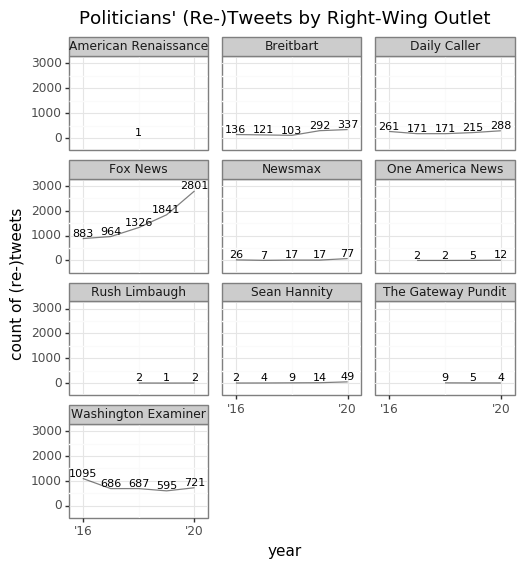

<ggplot: (8786868230747)>

In [240]:
plt_outlet_right_bw = (p9.ggplot(
                    data=df_urls.loc[df_urls["ideo_category"]=="right"], 
                    mapping=p9.aes(x='created_at_year'))
                 + p9.geom_line(color='black', stat='count', alpha = 0.5)
                 # + p9.scale_fill_manual(values=['black', 'darkgrey'])
                 + p9.geom_text(
                     p9.aes(label=p9.after_stat('count')),
                     stat='count',
                     va='bottom',
                     size=8
                 )
                 + p9.scale_x_datetime(labels=date_format("'%y"), date_breaks='4 years', expand=(0, 180, 0, 180))
                 + p9.scale_y_continuous(expand=(0,500)) # to prevent Fox label from getting cutoff
                 + p9.facet_wrap('outlet', labeller='label_value', ncol=3)
                 + p9.theme_bw()
                 + p9.theme(figure_size=(5.75, 6.0),
                         subplots_adjust={'wspace': 0.10,
                                          'hspace': 0.30
                                         }
                        )
                 + p9.labs(title="Politicians' (Re-)Tweets by Right-Wing Outlet",
                        fill='',
                        x='year',
                        y='count of (re-)tweets')
                )

display(plt_outlet_right_bw)

In [241]:
plt_outlet_right_bw.save(filename=os.path.join(figs_dir, "png", "outlets_right_shared_by_year_direct_bw.png"), height=5.5, width=5.5, units="in")

/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5.5 x 5.5 in image.
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../figures/direct/png/outlets_right_shared_by_year_direct_bw.png
/home/jovyan/.local/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
